In [1]:
# from qiskit import IBMQ
# from qiskit.providers.ibmq import least_busy

# IBMQ.save_account("4d7226ec37d38370454cbd7111e98a765d1cc1e6de0fa93a28a7b5918b6dd4b5c91f9fe74c748e270d8da2b5ef7c451b6550df0973de468ec4965a26b1b5c348", overwrite=True)
# provider = IBMQ.load_account()
# provider = IBMQ.get_provider('ibm-q')
# device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
#                                    not x.configuration().simulator and x.status().operational==True))
# print("Running on current least busy device: ", device)
# backend = provider.get_backend('ibmq_lima')


In [2]:
from qiskit import QuantumCircuit,  ClassicalRegister, transpile, Aer, IBMQ, execute
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.properties.second_quantization.electronic import ParticleNumber
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit.providers.aer import QasmSimulator
from qiskit_nature.algorithms import VQEUCCFactory, AdaptVQE
from qiskit.circuit.library import EfficientSU2, ExcitationPreserving
from qiskit.utils import QuantumInstance
from qiskit.algorithms.optimizers import SPSA, COBYLA, SLSQP, QNSPSA
from qiskit_nature.circuit.library.ansatzes import UCCSD
from qiskit_nature.circuit.library import HartreeFock
from qiskit.algorithms import VQE, NumPyEigensolver
# from qiskit import IBMQ 

# from libraries.vqe_ansatz import vqe
# from libraries.vqe_mitiq import VQE

from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy

# from qiskit import QuantumCircuit, execute

from qiskit.providers.aer.noise import NoiseModel



import numpy as np
backend = Aer.get_backend('qasm_simulator')

IBMQ.save_account(
    "4d7226ec37d38370454cbd7111e98a765d1cc1e6de0fa93a28a7b5918b6dd4b5c91f9fe74c748e270d8da2b5ef7c451b6550df0973de468ec4965a26b1b5c348",
    overwrite=True,
)
provider = IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")
# device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and
#                                    not x.configuration().simulator and x.status().operational==True))
# print("Running on current least busy device: ", device)


# Build noise model from backend properties
# provider = IBMQ.load_account()
# backend = provider.get_backend(str(device))
backend = provider.get_backend("ibm_nairobi")

noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map


bond_distance = 10
molecule = Molecule(geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, bond_distance]]], charge=0, multiplicity=1)
# molecule = Molecule(
#             geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, bond_distance]]],
#             charge=1.0,
#             multiplicity=2,
#         )  # H2+
driver = ElectronicStructureMoleculeDriver(molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF)
properties = driver.run()
particle_number = properties.get_property(ParticleNumber)
problem = ElectronicStructureProblem(driver)
# problem = ElectronicStructureProblem(driver, transformers=[FreezeCoreTransformer()])
converter = QubitConverter(JordanWignerMapper(), two_qubit_reduction=True)
second_q_ops = problem.second_q_ops()
main_op = second_q_ops[0]
num_particles = problem.num_particles
num_spin_orbitals = problem.num_spin_orbitals

# alpha, beta particles, Number of spin orbitals required for the given basis set
print(num_particles, num_spin_orbitals)
# print(properties)

(1, 1) 4


In [3]:
# Hamiltonian expression
qubit_op =  converter.convert(main_op, num_particles=num_particles)
print(qubit_op)

# Number of Qubits 
print(qubit_op.num_qubits)

-0.5987784482466018 * IIII
+ 0.03963943879866243 * IIIZ
+ 0.03963943879866416 * IIZI
+ 0.0396394387986624 * IZII
+ 0.039639438798664134 * ZIII
+ 0.013229430272999998 * IIZZ
+ 0.1034404581264839 * IZIZ
+ 0.09021102785348721 * YYYY
+ 0.09021102785348721 * XXYY
+ 0.09021102785348721 * YYXX
+ 0.09021102785348721 * XXXX
+ 0.1034404581264872 * ZIIZ
+ 0.1034404581264872 * IZZI
+ 0.10344045812649047 * ZIZI
+ 0.013229430272999998 * ZZII
4


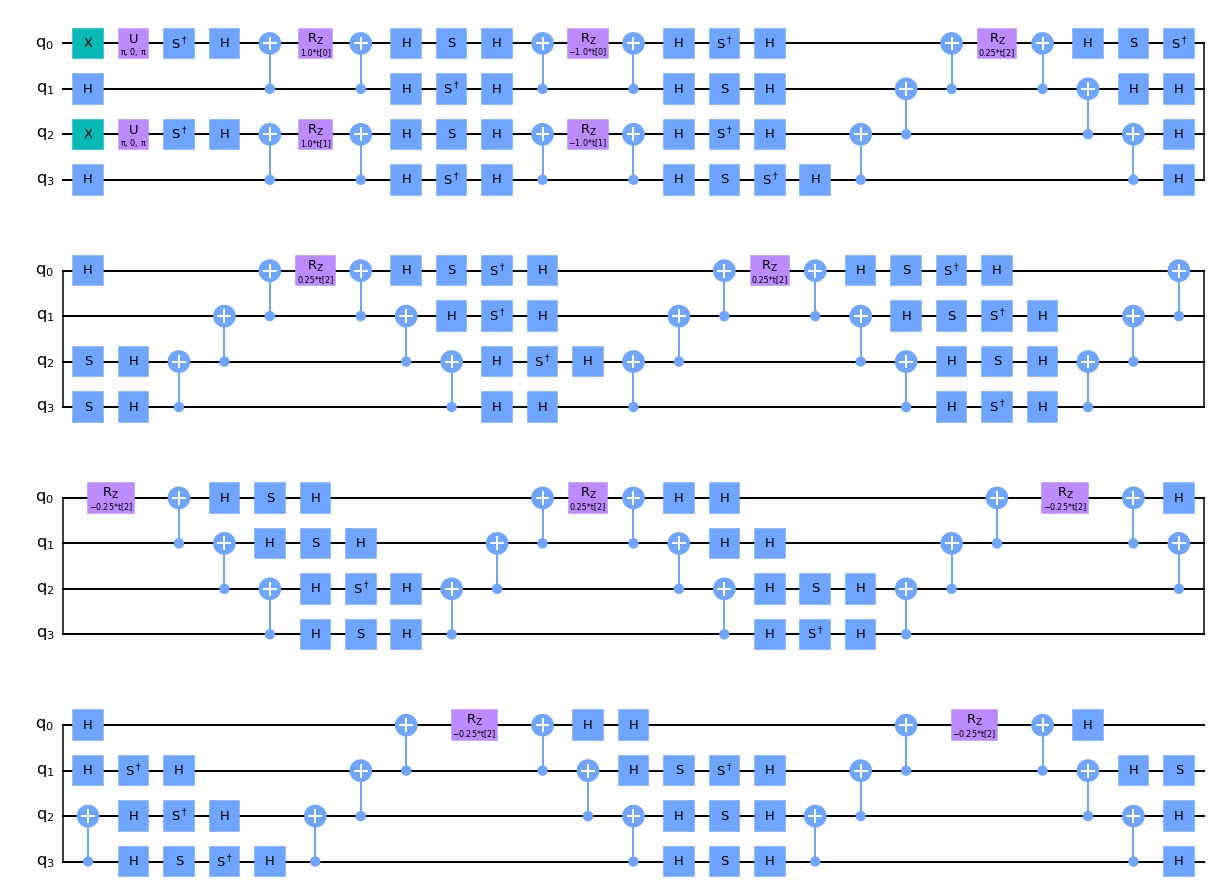

In [13]:
# backend = provider.get_backend('ibmq_bogota')
backend = Aer.get_backend('qasm_simulator')
simulation = QuantumInstance(backend=backend, shots=1024, noise_model=noise_model, coupling_map=coupling_map)
# simulation = QuantumInstance(backend=backend, shots=1000)


energy_vals = []
def vqe_callback(eval_count, opt_params, mean, stddev):
    print(eval_count, "mean=", mean)
    energy_vals.append(mean)

init_state = HartreeFock(num_spin_orbitals, num_particles, converter)

## Hardware Efficient ansatzes
# ansatz = EfficientSU2(qubit_op.num_qubits, entanglement="linear", reps=1,su2_gates=['rx', 'y'])
# num_vars = 2*vqe(ansatz_id=3).get_num_qubits()*vqe(ansatz_id=3).repitition
# params = np.random.randn(num_vars)

# ansatz = vqe(ansatz_id=3).get_ansatz(params)
# ansatz = ExcitationPreserving(num_spin_orbitals, mode = 'iswap', reps=1, entanglement='linear')
# ansatz.compose(init_state, front=True, inplace=True)
# ansatz = ansatz.decompose().decompose(gates_to_decompose=["rxx", "ryy"])
# ansatz.compose(init_state, front=True, inplace=True)

# ansatz = ansatz.decompose().decompose(gates_to_decompose=["rxx", "ryy"])
# ansatz.draw("mpl")

## UCCSD Ansatz
ansatz = UCCSD(qubit_converter=converter, num_particles=num_particles, num_spin_orbitals=num_spin_orbitals, reps=1, initial_state=init_state)
ansatz = ansatz.decompose().decompose().decompose()
ansatz.compose(init_state, front=True, inplace=True)
ansatz.draw("mpl")

# print(ansatz.qasm(formatted=True))

In [ ]:
# optimizer=SLSQP(maxiter=100, ftol = 0.1)
# optimizer=SPSA(maxiter=100)
optimizer=COBYLA(maxiter=120)

### Use VQEUCCFactory with UCCSD and EfficientSU2
# VQE = VQEUCCFactory(simulation, optimizer, include_custom=True, callback=vqe_callback, ansatz = ansatz)

### Use VQE with ExcitationPreserving
vqe = VQE(ansatz, optimizer=optimizer, quantum_instance=simulation, callback = vqe_callback)
result = vqe.compute_minimum_eigenvalue(qubit_op)
print(result)

# calculation = GroundStateEigensolver(converter,VQE)
# job = calculation.solve(problem)
# print(job)

In [ ]:
from qiskit import QuantumCircuit
import numpy as np

qc = QuantumCircuit(2)
qc.rxx(np.pi/2, 0, 1)
qc.ryy(np.pi/2, 0, 1)
qc.decompose().draw('mpl')
